## Quantum Machine Learning in HEP using Qibo

In the following we 
- *i)* give a look to some Qibo's primitives;
- *ii)* get familiar with Parametric Quantum Circuits (PQC);
- *iii)* train a PQC to fit the *up* quark Parton Distribution Function (PDF).

We will use a few Qibo's feature to handle points *i)*, *ii)* and *iii)*. 
If you are interested in delving deeper inside the code, please refer to our documentation: https://qibo.science/.

#### We can start with some imports

In [1]:
# plotting and numerics
import matplotlib.pyplot as plt
import numpy as np

# qibo modules/features
import qibo
from qibo import Circuit, gates, hamiltonians
from qibo.optimizers import optimize

We can select the most suitable engine on which we want to execute our quantum algorithm. 
<center><img src="https://raw.githubusercontent.com/MatteoRobbiati/Qibo-PyHEP/0e67d28f9183a616b16e9947d5041069f9a6e032/figures/backends.svg" alt="drawing" width="700"/></center>
In this notebook we will set the `numpy` backend, but all the available backends can be visualized using a dedicated qibo function.

In [93]:
# if we want to have a look to all the supported backends
qibo.list_available_backends()

{'numpy': True,
 'tensorflow': True,
 'pytorch': True,
 'qibojit': {'numba': True, 'cupy': False, 'cuquantum': False},
 'qibolab': False,
 'qibo-cloud-backends': False,
 'qibotn': {'cutensornet': False, 'qutensornet': False}}

In [94]:
# set qibo backend depending on your problem
qibo.set_backend(backend="numpy")

[Qibo 0.2.9|INFO|2024-06-27 15:47:39]: Using numpy backend on /CPU:0
[2024-06-27 15:47:39,721] INFO: Using numpy backend on /CPU:0


#### Some basic Quantum Computing notation

Every quantum state of a system of qubits can be described as linear combination of a basis of vectors, which are conventionally chosen to be the **computational basis**. The computational basis is constructed allowing every qubit of the system being represented by superposition of two elementary basis vectors $$ | \psi \rangle = \alpha_0 |0\rangle + \alpha_1 |1\rangle, \qquad \text{with} \qquad |0\rangle = \begin{bmatrix} 1 \\ 0 \end{bmatrix} \qquad |1\rangle = \begin{bmatrix} 0 \\ 1 \end{bmatrix}.$$
Combining all the possible states allowed by this notation, an $n$-qubits system corresponds to a $2^n$-components quantum state, with components $|x_i\rangle$.
$$ | \psi \rangle = \sum_{i=1}^{2^n} \alpha_i |x_i\rangle, \qquad \text{with} \qquad \sum_{i=1}^{2^n} |\alpha_i| = 1.$$
This state can thus be represented as a bitstring of length $2^n$.

In the following we will represent quantum states with bar plots; considering we prepare a quantum state applying a quantum circuit to the zero-th computational state $|10000..0\rangle$, we typically repeat che execution of a circuit $N_{\rm shots}$ times. Each circuit execution corresponds to a collapsed quantum state, namely the state collapses in one of the possible basis states $|x_i\rangle$ with probability $|\alpha_i|^2$. For this reason we have a natural **randomness** when executing a quantum system and, in practice, we can only collect $N_{\rm shots}$ frequencies. 

#### Some plotting functions

In [95]:
# visualize state in form of a bar plot
def visualize_state(counter):
    """Plot state's frequencies."""
        
    fig, ax = plt.subplots(figsize=(5, 5 * 6/8))
    ax.set_title('State visualization')
    ax.set_xlabel('States')
    ax.set_ylabel('#')
    plt.xticks(rotation=90)  
    for i, state in enumerate(counter):
            ax.bar(state, counter[state], color='#C194D8', edgecolor="black")
    plt.show()

# visualize labels and predictions in our QML problem
def plot_uquark(x, labels, predictions=None):
    """Plot target function and eventual predictions."""

    fig, ax = plt.subplots(figsize=(5, 5 * 6/8))
    ax.set_title(r'$u$-quark PDF')
    ax.set_xlabel('x')
    ax.set_ylabel(r'$u f(x)$')
    plt.plot(x, labels, color="black", ls="--", lw=1.5, label="Labels", marker=".", markersize=10, alpha=0.7)
    if predictions is not None:
        plt.plot(x, predictions, color="#C194D8", ls="-", lw=1.5, label="Predictions", marker=".", markersize=10, alpha=0.7)
    ax.set_xscale("log")
    plt.legend()
    plt.show()

### Exercise 1: preparing a Bell state

Bell's states are maximally entangled states for a single qubit system. One of them is:
$$ |b\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}. $$
As previously seen in the slides, it can be prepared by defining a two qubit system and applying a couple of gates to the system. In particular, we need to apply an Hadamard gate to the control qubit, creating a superposed state. Then we use it to control a NOT operation on the target qubit. The superposition of the first qubit will permit a parallel action on the target qubit, manipulating the whole system state to be into the desired entangled state.

<center><img src="https://github.com/MatteoRobbiati/Qibo-PyHEP/blob/main/figures/bell.png?raw=true" alt="drawing" width="300"/></center>

In [8]:
# To prepare the Bell state we need two qubits
nqubits = 2

# we initialize a circuit
c = Circuit(nqubits)
# we prepare superposition in the qubit labeled '0'
c.add(gates.H(0))
# we add a controlled-NOT operation with '0' as control and '1' as target
c.add(gates.CNOT(q0=0, q1=1))
# we add some measurements
c.add(gates.M(*range(nqubits)))

MeasurementResult(qubits=(0, 1), nshots=0)

We can visualize the circuit diagram calling the `circuit.draw` method.

In [10]:
print(c.draw())

q0: ─H─o─M─
q1: ───X─M─


Or we can print some information using the `circuit.summary` method.

In [11]:
print(c.summary())

Circuit depth = 3
Total number of gates = 3
Number of qubits = 2
Most common gates:
h: 1
cx: 1
measure: 1


The circuit outcome depends on the simulation one decides to run. We consider a run in which we set a number of shots $N_{\rm shots}=1000$.

In [17]:
# We can execute the circuit setting the number of shots
outcome = c(nshots=1000)

# print the state
print(f"The outcome of a simulation is a quantum state:\n{outcome}\n")
# print the theoretical (exact) probabilities
print(f"We can access the state probabilities:\n{outcome.probabilities()}\n")
# print the frequencies
print(f"and also the simulated frequencies:\n{outcome.frequencies()}.")

The outcome of a simulation is a quantum state:
(0.70711+0j)|00> + (0.70711+0j)|11>

We can access the state probabilities:
[0.5 0.  0.  0.5]

and also the simulated frequencies:
Counter({'11': 507, '00': 493}).


If we repeat the execution, the probabilities remain the same (they are an exact result) while the frequencies change.
We can also visualize the state using the plotting function defined above.

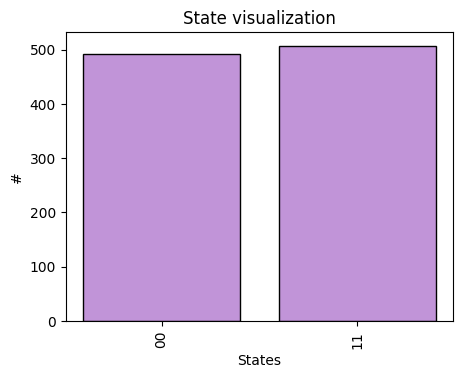

In [18]:
visualize_state(outcome.frequencies())

### Exercise 1.1: compute expectation values after executing a quantum circuit

The measurement gates are the tool we can use to measure the system. In practice, they correspond to some readout mechanism which returns a collection of zeros and ones on displays. In simulation mode, we can sample the frequencies of the state components from the probability vector, or reconstruct a collection of collapsed states using this same idea.

Depending on the simulation mode (with or without shots, namely shot-noisy or exact), we can compute expectation values of some target observable. This will be useful in the Quantum Machine Learning part of the notebook because we are going to use the expectation value of Pauli observable as predictor.

To get familiar with this, we can initialize one of the pre-computed hamiltonians in Qibo, e.g. the Transverse-Field Ising Model (TFIM)
$$ H = -\sum_{i=0}^N (Z_i Z_{i+1} + X_i). $$

In [19]:
# initialize it using the dedicated qibo module
h = hamiltonians.TFIM(nqubits=2, h=0.5)

# printing some features
print(f"Hamiltonian matrix:\n{h.matrix}")
print(f"\nEigenvalues:\n{h.eigenvalues()}")
print(f"\nEigenvectors:\n{h.eigenvectors()}")

Hamiltonian matrix:
[[-2. -0.j -0.5-0.j -0.5-0.j -0. -0.j]
 [-0.5-0.j  2. -0.j -0. -0.j -0.5-0.j]
 [-0.5-0.j -0. -0.j  2. -0.j -0.5-0.j]
 [-0. -0.j -0.5-0.j -0.5-0.j -2. -0.j]]

Eigenvalues:
[-2.23606798 -2.          2.          2.23606798]

Eigenvectors:
[[ 6.88190960e-01+0.j  7.07106781e-01+0.j -3.33066907e-16-0.j
  -1.62459848e-01+0.j]
 [ 1.62459848e-01+0.j  3.83491058e-17+0.j  7.07106781e-01+0.j
   6.88190960e-01+0.j]
 [ 1.62459848e-01+0.j  3.83491058e-17+0.j -7.07106781e-01+0.j
   6.88190960e-01+0.j]
 [ 6.88190960e-01+0.j -7.07106781e-01+0.j -4.44089210e-16+0.j
  -1.62459848e-01+0.j]]


Now we can execute a quantum circuit and use the final state to compute the expectation value of $H$ as 
$$ E = \langle 0 | U^{\dagger} H U | 0 \rangle. $$

In [20]:
final_state = c(nshots=1000).state()
expval = h.expectation(final_state)
print(expval)

-1.9999999999999996


### Parametric quantum circuits

We can also build some more complex quantum circuit, using gates which depend on some parameter. 

The most used parametric gates are rotations: $R_k = \exp [-i\theta \sigma_k]$, which are parametric through the rotation angle $\theta$ and are generated by the Pauli operators $\sigma_k$ ($k$ here is $x, y$ or $z$).

In [23]:
def build_parametric_circuit(nlayers):
    """Construct the scheleton of the parametric quantum circuit repeating a schema `nlayers` times."""
    c = Circuit(1)
    for _ in range(nlayers):
        c.add(gates.RY(q=0, theta=0.))
        c.add(gates.RZ(q=0, theta=0.))
    c.add(gates.M(0))
    return c

We can print some information about the parametric quantum circuit.

In [22]:
pqc = build_parametric_circuit(nlayers=3)
print(c.draw(), "\n")
print(c.summary())

q0: ─H─o─M─
q1: ───X─M─ 

Circuit depth = 3
Total number of gates = 3
Number of qubits = 2
Most common gates:
h: 1
cx: 1
measure: 1


#### Manipulating circuit's parameters

We can access to circuit's parameters using the `circuit.get_parameters` method and similarly we can update their values using the `circuit.set_parameters` method.

Since we initialized the circuit setting every $\theta$ to be equal to zero, we expect this circuit to not act on the initial state.

In [26]:
# we set them to be zero!
print(pqc.get_parameters())

[(0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,)]


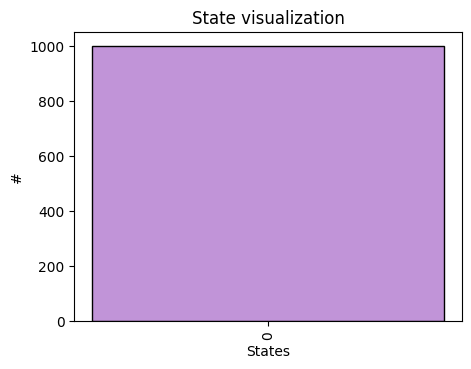

In [27]:
# and thus we expect them to do nothing on the ground state
visualize_state(pqc(nshots=1000).frequencies())

If now we change the parameters values randomly, e.g. generating random numbers using Numpy, we expect the state to move from $|0\rangle$ to a superposition of the two computational basis vectors.

In [28]:
# generating new parameters values
np.random.seed(42)
nparams = len(pqc.get_parameters())
new_parameters = np.random.randn(nparams)

# injecting them into the circuit
pqc.set_parameters(new_parameters)
print(pqc.get_parameters())

[(0.4967141530112327,), (-0.13826430117118466,), (0.6476885381006925,), (1.5230298564080254,), (-0.23415337472333597,), (-0.23413695694918055,)]


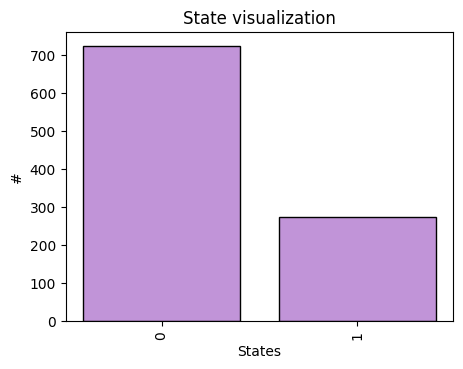

In [29]:
# plotting the frequencies
visualize_state(pqc(nshots=1000).frequencies())

### Exercise 2: training a parametric circuit to fit a PDF

Now we need to combine everything together building a simple QML pipeline to handle a target problem. Let us recall the QML scheme presented in the slides:
<center><img src="https://github.com/MatteoRobbiati/Qibo-PyHEP/blob/main/figures/qml_scheme.png?raw=true" alt="drawing" width="800"/></center>

At first, we need to prepare the training data. We will use data from the NNPDF 4.0 grid as labels.

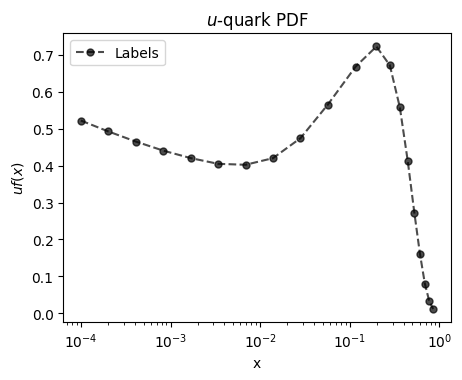

In [96]:
# load data
data = np.loadtxt("data/u.dat")

x_data = data.T[0]
labels = data.T[1]

indexes = np.arange(0, len(labels), 5)
x_data = x_data[indexes]
labels = labels[indexes]

# plot training data
plot_uquark(x_data, labels)

Then we need to define a schema to upload the input data into the quantum circuit together with some variational parameters. For this, we define the following `set_parameters` function.

In [97]:
def set_parameters(circuit, nlayers, parameters, x):
    """
    Upload data and trainable parameters into a circuit.
    We want to combine data and params so that angle = p1 * x + p2
    """
    params = []
    index = 0
    for _ in range(nlayers):
        params.append(parameters[index] * x + parameters[index + 1])
        params.append(parameters[index + 2] * np.log(x) + parameters[index + 3])
        index += 4
    circuit.set_parameters(params)
    return circuit

Then, we need a function to compute predictions for all the points of the training set. We are going to call it `predict` and we make use of the expectation function of a target observable to compute the predictions. In particular, since the PDF are defined into [0,1], we use a non interacting Pauli Z as observable: 
$$ Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}.$$
Whose expectation value is defined in [-1,1].

In [76]:
# predictions
def predict(parameters, data, nlayers, circuit, hamiltonian):
    """Compute predictions given dataset and parameters."""
    predictions = []
    for x in data:
        circuit = set_parameters(circuit, nlayers, parameters, x)
        predictions.append(hamiltonian.expectation(circuit().state()))
    return predictions

We also need a loss function to quantify the goodness of our predictions! We can choose a Mean-Squared Error (MSE) loss function:
$$ MSE = \frac{1}{M} \sum_{i=1}^M \bigl[ E_{\vec{\theta}}(x_i) - y_i\bigr]^2, $$
where our prediction $E_{\vec{\theta}}(x_i)$ is the expected value of $Z$ over the state we get executing the circuit in which we inject both $\vec{\theta}$ and $x_i$, while $y_i$ is the NNPDF label associated to the input value $x_i$.

In [77]:
def loss_function(parameters, data, labels, circuit, nlayers, hamiltonian):
    """Compute loss function considering all data and a given set of parameters."""
    loss = 0
    predictions = predict(parameters, data, nlayers, circuit, hamiltonian)
    for i, pred in enumerate(predictions):
        loss += (pred - labels[i])**2
    return loss / len(labels)

We can now define a number of layers and set up the training.

In [87]:
# define the parametric quantum circuit
nlayers = 4
pqc = build_parametric_circuit(nlayers)

np.random.seed(42)
initial_parameters = np.random.randn(nlayers * 4)
pqc = set_parameters(pqc, nlayers, initial_parameters, 0.3)

# define the observable
h = hamiltonians.Z(1)

In [88]:
print(pqc.draw())

q0: ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─M─


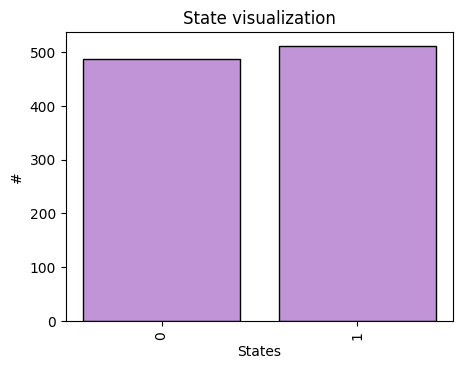

In [89]:
visualize_state(pqc(nshots=1000).frequencies())

We can have a look to the initial prediction of the model, which are expected to be random (not well predicting).

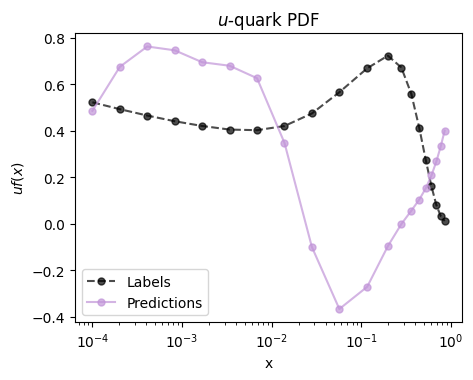

In [90]:
predictions = predict(initial_parameters, x_data, nlayers, pqc, h)
plot_uquark(x_data, labels, predictions)

The final element we need is the choice of the optimizer. What we need is an algorithm to which we delegate the updating of the parameters. We will use a Genetic Algorithm, in particular the Covariance Matrix Adaptation Evolution Strategy. This, among many other optimizers, can be used calling the `qibo.optimizers.optimize` function setting `method="cma"`.  

In [91]:
# THIS CELL COULD REQUIRE A COUPLE OF MINUTES OF TIME TO BE EXECUTED
optimization_result = optimize(loss_function, initial_parameters=initial_parameters, method="cma", args=(x_data, labels, pqc, nlayers, h), options={"maxiter": 1500})

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 16 (seed=596508, Thu Jun 27 15:42:20 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.878836319737041e-01 1.0e+00 1.58e+00  2e+00  2e+00 0:00.1
    2     24 7.611678913022948e-02 1.1e+00 1.52e+00  1e+00  2e+00 0:00.2
    3     36 3.073917918515791e-01 1.1e+00 1.49e+00  1e+00  2e+00 0:00.2
   55    660 9.983515531026535e-02 2.1e+00 7.02e-01  6e-01  8e-01 0:03.3
  100   1200 6.366585751181731e-03 2.7e+00 1.57e-01  9e-02  2e-01 0:05.9
  187   2244 1.293793635538801e-04 8.0e+00 2.51e-02  9e-03  3e-02 0:10.9
  200   2400 8.897236244940456e-05 9.0e+00 1.59e-02  5e-03  2e-02 0:11.7
  300   3600 2.597851483435863e-05 4.2e+01 8.78e-03  2e-03  1e-02 0:17.5
  400   4800 8.993227955682139e-06 1.4e+02 8.44e-03  1e-03  2e-02 0:23.3
  500   6000 6.667541684203708e-06 2.0e+02 5.12e-03  8e-04  1e-02 0:29.1
  600   7200 5.480463570751733e-06 2.2e+02 5.15e-03  8e-04  1e-02 0:34.9
  700   8400 3.658416988261278e-0

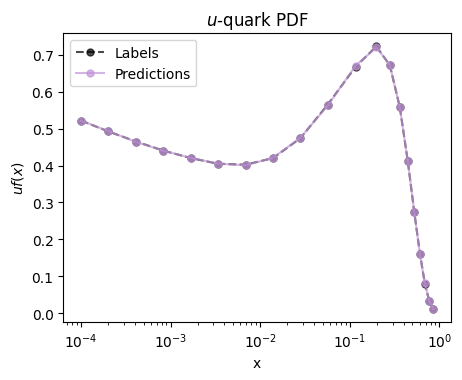

In [92]:
best_params = optimization_result[1]
predictions = predict(best_params, x_data, nlayers, pqc, h)
plot_uquark(x_data, labels, predictions)